In [2]:
!pip install langchain langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00


In [5]:
!pip install langchain-community --upgrade
!pip install langchain --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [6]:
from langgraph.graph import StateGraph
from langchain.chat_models import ChatOpenAI

In [68]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict

# Define the state object that tracks the workflow
class InvoiceState(TypedDict):
    invoice_id: str
    po_number: str
    is_paid: bool
    payment_method: str
    payment_date: str
    exception_status: str
    action_taken: str

# Initialize the StateGraph
builder = StateGraph(InvoiceState)

# Define nodes for each step in the workflow

In [69]:
def imagenow_check(state: InvoiceState):
    print("\n=== Imagenow Check ===")
    # Simulate checking the invoice in Imagenow
    state['is_paid'] = True  # Replace with actual API query result
    print(f"Invoice {state['invoice_id']} paid status: {state['is_paid']}")
    return state

def lawson_payment_check(state: InvoiceState):
    print("\n=== Lawson Payment Check ===")
    # Simulate Lawson check for payment details
    state['payment_method'] = "Wire Transfer"
    state['payment_date'] = "2025-01-05"
    print(f"Payment Method: {state['payment_method']}, Payment Date: {state['payment_date']}")
    return state


def email_response_node(state: InvoiceState):
    print("\n=== Email Response Node ===")
    if state['is_paid']: # Corrected to is_paid
        print("Drafting email to vendor using LLM...")
        prompt = (
            f"Draft a professional email to inform the vendor that the payment for invoice {state['invoice_id']} has been processed. "
            f"Include the payment method ({state['payment_method']}) and payment date ({state['payment_date']})."
        )
        state['email_draft'] = llm.invoke(prompt).content
        print(f"Email Draft: {state['email_draft']}")
    return state

def ivalua_check(state: InvoiceState):
    print("\n=== Ivalua Check ===")
    # Simulate checking Ivalua for transmission status
    state['exception_status'] = "Transmitted"
    print(f"Ivalua status for PO {state['po_number']}: {state['exception_status']}")
    return state

def email_personnel(state: InvoiceState):
    print("\n=== Email Personnel ===")
    # Simulate emailing the appropriate person based on exception status
    state['action_taken'] = f"Email sent for exception: {state['exception_status']}"
    print(state['action_taken'])
    return state

def update_notes(state: InvoiceState):
    print("\n=== Update Notes ===")
    # Simulate updating notes in Imagenow/Ivalua
    state['action_taken'] += " | Notes updated in Imagenow/Ivalua"
    print(state['action_taken'])
    return state

In [70]:
# Define conditional transitions

def check_payment_status(state: InvoiceState):
    print("\n=== Conditional Check: Payment Status ===")
    if state['is_paid']:
        return "lawson_payment_check"
    elif len(state['po_number']) == 11:
        return "ivalua_check"
    else:
        return "lawson_exception_check"

def ivalua_exception_handling(state: InvoiceState):
    print("\n=== Conditional Check: Ivalua Exception Handling ===")
    if state['exception_status'] == "Transmitted":
        return "lawson_payment_check"
    else:
        return "email_personnel"

In [71]:
# Add nodes to the graph
builder.add_node("imagenow_check", imagenow_check)
builder.add_node("lawson_payment_check", lawson_payment_check)
builder.add_node("email_response_node", email_response_node)
builder.add_node("ivalua_check", ivalua_check)
builder.add_node("email_personnel", email_personnel)
builder.add_node("update_notes", update_notes)

# Add conditional edges
builder.add_conditional_edges("imagenow_check", check_payment_status, {
    "lawson_payment_check": "lawson_payment_check",
    "ivalua_check": "ivalua_check",
    "lawson_exception_check": "email_personnel",
})

builder.add_conditional_edges("ivalua_check", ivalua_exception_handling, {
    "lawson_payment_check": "lawson_payment_check",
    "email_personnel": "email_personnel",
})

# Add normal edges

builder.add_edge("lawson_payment_check", "email_response_node")
builder.add_edge("email_personnel", "update_notes")
builder.add_edge("email_response_node", "update_notes")


In [72]:
# Set the entry point
builder.set_entry_point("imagenow_check")

# Compile the graph
graph = builder.compile()

In [19]:
!apt-get install graphviz graphviz-dev # Install Graphviz using apt
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

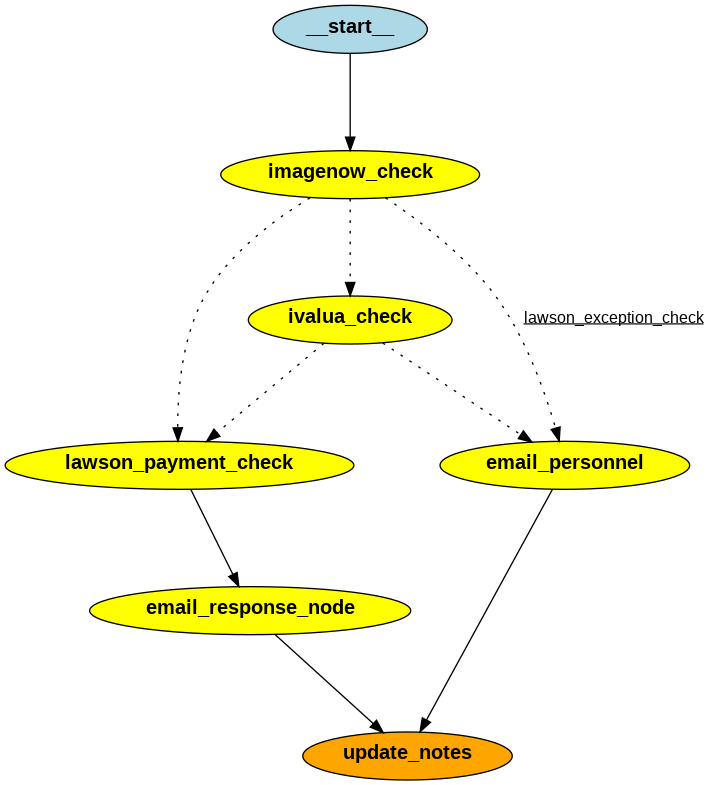

In [73]:
from IPython.display import Image

# Assuming `graph.get_graph()` provides a graph object and `.draw_png()` generates a PNG image
# Visualize the graph in a Jupyter notebook
Image(graph.get_graph().draw_png())

In [74]:
# Execute the workflow
state = InvoiceState(
    invoice_id="INV123456",
    po_number="12345678901",  # Example 11-digit PO
    is_paid=True,
    payment_method="",
    payment_date="",
    exception_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)


=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV123456 paid status: True

=== Conditional Check: Payment Status ===

=== Lawson Payment Check ===
Payment Method: Wire Transfer, Payment Date: 2025-01-05

=== Email Response Node ===
Drafting email to vendor using LLM...
Email Draft: Subject: Payment Confirmation for Invoice INV123456

Dear [Vendor's Name],

I hope this message finds you well.

I am writing to inform you that the payment for invoice INV123456 has been processed. The payment was made via wire transfer on January 5, 2025.

Please let us know if you require any further information or documentation regarding this transaction.

Thank you for your continued partnership.

Best regards,

[Your Name]  
[Your Position]  
[Your Company]  
[Your Phone Number]  
[Your Email Address]  

=== Update Notes ===
 | Notes updated in Imagenow/Ivalua


{'invoice_id': 'INV123456',
 'po_number': '12345678901',
 'is_paid': True,
 'payment_method': 'Wire Transfer',
 'payment_date': '2025-01-05',
 'exception_status': '',
 'action_taken': ' | Notes updated in Imagenow/Ivalua'}